## Standardize the item response data

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
# https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py

from sklearn.metrics import confusion_matrix

from funcs import *
from clustering import *
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# sort 
def sort_labels(labels, data):
    num_cluster = np.max(labels) + 1
    sorted_index = np.argsort([np.mean(np.mean(data[labels == i] ,axis=0)) for i in range(num_cluster)])[::-1]
    sorted_labels = sort_categories_by_mean(labels, sorted_index)
    
    return sorted_labels

In [3]:
data = pd.read_csv('data/final.csv', index_col = 'Unnamed: 0')

In [4]:
type_A = data[data['type'] == 'A']

print(type_A.shape)

(56, 16)


In [6]:
A_response = np.array(type_A.iloc[:,1:13])

In [9]:
data_standardized_A = (A_response - np.mean(A_response, axis=0)) / np.std(A_response, axis=0)

In [10]:
data_standardized_A.shape

(56, 12)

In [11]:
# plt.imshow(response_data, cmap='gray')
#data_standardized.shape

## Initialize using PCA & k-means

In [12]:
num_components = 8
num_clusters = 3


itr = 0
all_labels = []

fit_pca = PCA(n_components=num_components, random_state=0).fit_transform(data_standardized_A)
print(fit_pca.shape)

# clustering by k-means 
km_pca = KMeans(n_clusters=num_clusters, random_state=0).fit(fit_pca)

labels = sort_labels(km_pca.labels_, data_standardized_A)
print(labels.shape)

all_labels.append(labels)


(56, 8)
(56,)


## update by iterating LDA and k-means

In [13]:
max_itr = 5


lda = LinearDiscriminantAnalysis()
km = KMeans(n_clusters=num_clusters, random_state=0)

for itr in range(1, max_itr+1):
    # 1. fit LDA with original (hig-dim) data and current label
    lda.fit(data_standardized_A, labels)

#     labels_lda = sort_labels(lda.predict(data_standardized), data_standardized)
    
#     # compare labels
#     cm = confusion_matrix(labels, labels_lda)
#     print(cm)

    # 2. project using LDA
    U = lda.coef_
    print(U.shape)

    # normalize U
    norm = np.sqrt(np.sum(U ** 2,axis=1)).reshape((-1,1))
    U = U / norm

    projected = np.dot(data_standardized_A, U.T)
#     print(projected.shape)

    # 3. k-means clustering
    km_lda = km.fit(projected)

    labels_lda_km = sort_labels(km_lda.labels_, data_standardized_A)

    # compare labels
    cm = confusion_matrix(labels, labels_lda_km)
    print(cm)

    labels = labels_lda_km

(3, 12)
[[26  0  0]
 [ 1 19  1]
 [ 0  0  9]]
(3, 12)
[[27  0  0]
 [19  0  0]
 [ 0 10  0]]
(1, 12)
[[46  0]
 [ 0 10]]
(1, 12)
[[46  0]
 [ 0 10]]
(1, 12)
[[46  0]
 [ 0 10]]


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)


In [14]:
labels

array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

## [TODO] Visualize with `labels`

* Itemwise

In [15]:
itemwise_km = [np.mean(data_standardized_A[labels == i+1], axis=0) for i in range(num_clusters)]

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


/usr/local/lib/python3.6/dist-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


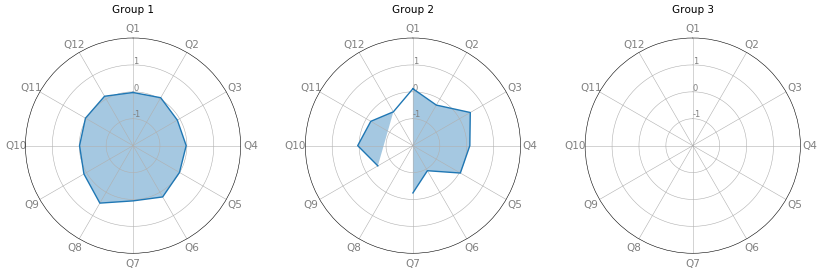

In [17]:
my_dpi=50
plt.figure(figsize=(1000/my_dpi, 750/my_dpi), dpi=my_dpi)

items = ['Q'+ str(i+1) for i in range(data_standardized_A.shape[1])]

for row in range(0, len(itemwise_km)):
    ax = plt.subplot(1,num_clusters,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = itemwise_km[row]
    make_spider(items, values, row, ax, 'Group ' + str(row + 1), 'solid')

* Componentwise

In [22]:
#componentwise_km = list()

#for i in range(1,num_clusters + 1):
#    componentwise_km.append(calc_mean_components_by_group(items_for_each_component, itemwise_km, i))

In [21]:
'''
my_dpi=50
plt.figure(figsize=(1000/my_dpi, 750/my_dpi), dpi=my_dpi)

components = ['C'+str(i+1) for i in range(len(items_for_each_component.keys()))]

for row in range(0, len(componentwise_km)):
    ax = plt.subplot(1,num_clusters,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = componentwise_km[row].values()
    make_spider(components, values, row, ax, 'Group '+ str(row + 1))
'''

"\nmy_dpi=50\nplt.figure(figsize=(1000/my_dpi, 750/my_dpi), dpi=my_dpi)\n\ncomponents = ['C'+str(i+1) for i in range(len(items_for_each_component.keys()))]\n\nfor row in range(0, len(componentwise_km)):\n    ax = plt.subplot(1,num_clusters,row + 1, polar=True)\n    plt.subplots_adjust(wspace=0.3)\n    values = componentwise_km[row].values()\n    make_spider(components, values, row, ax, 'Group '+ str(row + 1))\n"